<a href="https://colab.research.google.com/github/ikonushok/My_projects/blob/main/%D0%A0%D0%B0%D0%B7%D0%B1%D0%BE%D1%80_HW4_Pro_%D0%A3%D0%B3%D0%BB%D1%83%D0%B1%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B2_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, GRU, Embedding, Bidirectional, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#NER : Named Entity Recognition
-----
статья по NER: https://sysblok.ru/glossary/named-entity-recognition-ner/

NER - это имена людей, названия организаций, книг, городов, и другие имена собственные называют «именованные сущности» (named entities), а саму задачу — «распознавание именованных сущностей». По-английски «Named entity recognition».

За одной задачей NER, на самом деле, стоит две: 
1. обнаружить, что какая-то последовательность слов — это именованная сущность; 
2. понять, к какому классу (имя человека, название организации, город и т.п.) эта именованная сущность относится. На каждом из этапов возникают свои сложности

## Загружаем данные

In [ ]:
df = pd.read_csv('/content/ner.csv', 
                 encoding = "ISO-8859-1", error_bad_lines=False, index_col=0)

b'Skipping line 281837: expected 25 fields, saw 34\n'
/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
df = df.drop_duplicates()
df.head()

,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,pos,prev-iob,prev-lemma,prev-pos,prev-prev-iob,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,NNS,__START1__,__start1__,__START1__,__START2__,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,IN,O,thousand,NNS,__START1__,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,NNS,O,of,IN,O,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,VBP,O,demonstr,NNS,O,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,march,through,london,NNP,capitalized,London,IN,lowercase,through,VBN,O,have,VBP,O,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O


Наша задача - сказать для каждого слова его класс.

Или 0, или какая-то сущность

In [ ]:
# оставим в датафрейме только ключевые для нас данные
# Y - это наш tag, окторый позже переведем в ohe
# Х - это word
df = df[['sentence_idx', 'word','tag']]
df

,sentence_idx,word,tag
0,1.0,Thousands,O
1,1.0,of,O
2,1.0,demonstrators,O
3,1.0,have,O
4,1.0,marched,O
...,...,...,...
1048570,47959.0,they,O
1048571,47959.0,responded,O
1048572,47959.0,to,O
1048573,47959.0,the,O


## Подготавливаем данные

При разметке именованных сущностей принято использовать формат BIOES:
- «B» (beginning) для обозначения первого слова
- «I» (intermediate) — для всех слов между
- «O» (нет сущности)
- «E» (end) для последнего слова
- Иногда также используется префикс «S» (single) для обозначения именованной сущности, состоящей из одного слова

In [ ]:
# смотрим на нашу разметку
df['tag'].unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat', nan], dtype=object)

In [ ]:
# определяем максимальное число предложений
max_idx = int(df.sentence_idx.max())
max_idx

47959

In [ ]:
# Смотрим, на предложение 1
df.loc[df['sentence_idx']==1, 'word']

0         Thousands
1                of
2     demonstrators
3              have
4           marched
5           through
6            London
7                to
8           protest
9               the
10              war
11               in
12             Iraq
13              and
14           demand
15              the
16       withdrawal
17               of
18          British
19           troops
20             from
21             that
22          country
23                .
Name: word, dtype: object

In [ ]:
# создаем списки для последовательностей слов и для тегов
sequences = [] #  список списков слов (корпус слов)
tags = [] # корпус тегов
for i in range(1, max_idx+1): # проходимся по индексам предложений
  sequences.append(df.loc[df['sentence_idx']==i, 'word'].values.tolist())
  tags.append(df.loc[df['sentence_idx']==i, 'tag'].values.tolist())

# посмотрим пример того, чо внутри корпусов
print(sequences[2])
print(tags[2])

['They', 'marched', 'from', 'the', 'Houses', 'of', 'Parliament', 'to', 'a', 'rally', 'in', 'Hyde', 'Park', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'I-geo', 'O']


In [ ]:
# соединили пробелами в предложение для того, чтобы напитать Tokenizer
sequences_ = [' '.join(sequence) for sequence in sequences]
sequences_[2] # пример того, что получилось

'They marched from the Houses of Parliament to a rally in Hyde Park .'

In [ ]:
# параметры для Tokenizer
num_words = 5000 # число слов в словаре
sent_len = 5 # длина предложения

In [ ]:
# создаем Tokenizer
tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(sequences_) # получаем словарь частотности
tokenizer.index_word

{1: 'the',
 2: 'in',
 3: 'of',
 4: 'to',
 5: 'a',
 6: 'and',
 7: "'s",
 8: 'for',
 9: 'has',
 10: 'on',
 11: 'is',
 12: 'that',
 13: 'have',
 14: 'u',
 15: 'with',
 16: 'said',
 17: 'was',
 18: 'at',
 19: 'says',
 20: 's',
 21: 'from',
 22: 'by',
 23: 'he',
 24: 'an',
 25: 'as',
 26: 'say',
 27: 'it',
 28: 'are',
 29: 'were',
 30: 'his',
 31: 'officials',
 32: 'president',
 33: 'will',
 34: 'government',
 35: 'mr',
 36: 'two',
 37: 'been',
 38: 'killed',
 39: 'people',
 40: 'not',
 41: 'after',
 42: 'its',
 43: 'but',
 44: 'be',
 45: 'they',
 46: 'more',
 47: 'also',
 48: 'year',
 49: 'new',
 50: 'united',
 51: 'military',
 52: 'last',
 53: 'who',
 54: 'country',
 55: 'police',
 56: 'than',
 57: 'one',
 58: 'minister',
 59: 'iraq',
 60: 'their',
 61: 'security',
 62: 'which',
 63: 'this',
 64: 'about',
 65: 'other',
 66: 'states',
 67: 'had',
 68: 'least',
 69: 'state',
 70: 'three',
 71: 'tuesday',
 72: 'group',
 73: 'iran',
 74: 'forces',
 75: 'week',
 76: 'world',
 77: 'since',
 78:

In [ ]:
# формируем Х
X = tokenizer.texts_to_sequences(sequences_)
X = pad_sequences(X, sent_len)
X.shape # вот это пойдет в Embedding

(47959, 5)

In [ ]:
# создаем частотность тегов
tags = [' '.join(tag) for tag in tags]
tag_tokenizer = Tokenizer(df.tag.nunique(), filters=' ')
tag_tokenizer.fit_on_texts(tags)
tag_tokenizer.index_word
# нужно учесть, что начинается с 1, а не с 0
# поэтому перед преобразованием softmax нужно будет вычитать 1

{1: 'o',
 2: 'b-geo',
 3: 'b-tim',
 4: 'b-org',
 5: 'i-per',
 6: 'b-per',
 7: 'i-org',
 8: 'b-gpe',
 9: 'i-geo',
 10: 'i-tim',
 11: 'b-art',
 12: 'b-eve',
 13: 'i-eve',
 14: 'i-art',
 15: 'b-nat',
 16: 'i-gpe',
 17: 'i-nat'}

In [ ]:
Y = tag_tokenizer.texts_to_sequences(tags) # получаем набор из тегов
Y = pad_sequences(Y, sent_len, value=1)
Y.shape

(47959, 5)

In [ ]:
Y = to_categorical(Y, df.tag.nunique()+1) # увеличиваем на 1 число классов
Y.shape

(47959, 5, 18)

In [ ]:
Y = Y[:, :, 1:] # обрезали на 1 с конца чтобы уровнять размерность с Х
Y.shape

(47959, 5, 17)

## Создаем и обучаем Нейронную сеть

In [ ]:
emb_size = 10

input = Input(shape=(None,))
x = Embedding(num_words, emb_size)(input)
# обязательно указывать return_sequences=True для того, чтобы
# для каждого слова был его класс
x = Bidirectional(LSTM(emb_size, return_sequences=True))(x)
x = LSTM(emb_size * 2, return_sequences=True)(x)
x = Dense(df.tag.nunique(), activation='softmax')(x) # df.tag.nunique() - число классов
#output = CRF()(x)

model = Model(input, x)

In [ ]:
# коллбэки
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.5, patience=1, min_lr=1e-07, verbose = 1)

model.compile(optimizer=Adam(learning_rate = 1e-02),
              loss='categorical_crossentropy', metrics=['accuracy'])

# fit model
history = model.fit(X, Y, validation_split=0.2,
          epochs = 10, verbose = 1,
          callbacks = reduce_lr)

Epoch 1/10
1199/1199 [==============================] - 17s 11ms/step - loss: 0.4984 - accuracy: 0.9055 - val_loss: 0.3774 - val_accuracy: 0.9046
Epoch 2/10
1199/1199 [==============================] - 13s 11ms/step - loss: 0.2105 - accuracy: 0.9444 - val_loss: 0.3006 - val_accuracy: 0.9212
Epoch 3/10
1199/1199 [==============================] - 13s 11ms/step - loss: 0.1662 - accuracy: 0.9538 - val_loss: 0.2958 - val_accuracy: 0.9242
Epoch 4/10
1199/1199 [==============================] - 13s 11ms/step - loss: 0.1391 - accuracy: 0.9601 - val_loss: 0.2913 - val_accuracy: 0.9266
Epoch 5/10
1199/1199 [==============================] - 14s 11ms/step - loss: 0.1260 - accuracy: 0.9634 - val_loss: 0.2999 - val_accuracy: 0.9283

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 6/10
1199/1199 [==============================] - 13s 11ms/step - loss: 0.1064 - accuracy: 0.9683 - val_loss: 0.3103 - val_accuracy: 0.9262

Epoch 00006: ReduceLROnPlateau reducing lea

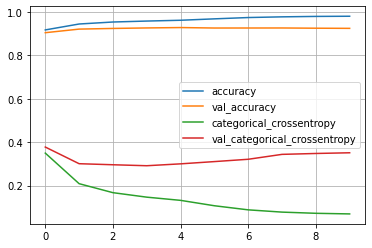

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='categorical_crossentropy')
plt.plot(history.history['val_loss'], label='val_categorical_crossentropy')
plt.legend()
plt.grid()
plt.show()

# Модель c CRF

In [ ]:
!pip install tf2crf
from tf2crf import CRF
from tf2crf import CRF, ModelWithCRFLoss

In [ ]:
Y = tag_tokenizer.texts_to_sequences(tags)
Y = pad_sequences(Y, sent_len, value=1)

In [ ]:
emb_size = 10

inputs = Input(shape=(None,))
x = Embedding(num_words, emb_size)(inputs)
x = Bidirectional(LSTM(emb_size, return_sequences=True))(x)
x = LSTM(emb_size * 2, return_sequences=True)(x)
x = Dense(df.tag.nunique(), activation=None)(x) # ставим activation=None согласно рекомендациям в документации

crf = CRF()
output = crf(x)

base_model = Model(inputs, output)
model = ModelWithCRFLoss(base_model)

In [ ]:
# коллбэки
reduce_lr = ReduceLROnPlateau(monitor = 'crf_loss', factor=0.5, patience=1, min_lr=1e-07, verbose = 1)

model.compile(optimizer=Adam(learning_rate = 1e-02),
              loss='categorical_crossentropy', metrics=['accuracy'])

# fit model
history = model.fit(X, Y, validation_split=0.2,
          epochs = 10, verbose = 1,
          callbacks = reduce_lr)

Epoch 1/10
1199/1199 [==============================] - 40s 28ms/step - crf_loss: 0.4698 - accuracy: 0.9631 - val_crf_loss_val: 0.8592 - val_val_accuracy: 0.9282
Epoch 2/10
1199/1199 [==============================] - 32s 27ms/step - crf_loss: 0.4263 - accuracy: 0.9658 - val_crf_loss_val: 0.9769 - val_val_accuracy: 0.9261

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 3/10
1199/1199 [==============================] - 32s 27ms/step - crf_loss: 0.3420 - accuracy: 0.9714 - val_crf_loss_val: 1.1087 - val_val_accuracy: 0.9261
Epoch 4/10
1199/1199 [==============================] - 32s 27ms/step - crf_loss: 0.2997 - accuracy: 0.9750 - val_crf_loss_val: 1.2548 - val_val_accuracy: 0.9230

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
Epoch 5/10
1199/1199 [==============================] - 32s 27ms/step - crf_loss: 0.2498 - accuracy: 0.9793 - val_crf_loss_val: 1.4315 - val_val_accuracy: 0.9229
Epoch 6/10
1199/1199 [=======

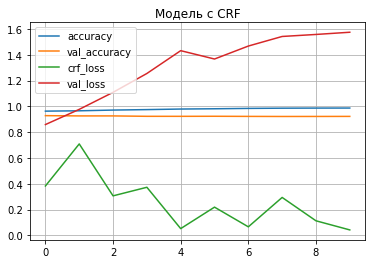

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_val_accuracy'], label='val_accuracy')
plt.plot(history.history['crf_loss'], label='crf_loss')
plt.plot(history.history['val_crf_loss_val'], label='val_loss')
plt.legend()
plt.title('Модель c CRF')
plt.grid()
plt.show()